In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, Column
import re
from tqdm.notebook import tqdm
from scikitplot.metrics import plot_confusion_matrix
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
SPECTRAL_NAMES = np.array(['UNKNOWN', 'O', 'B', 'A', 'F', 'G', 'K', 'M'])
LUMINOSITY_NAMES = np.flip(np.array(['I', 'II', 'III', 'IV', 'V']))

SED_RE = re.compile('uk([rw]?)(\w\d+(\.\d+)?)(\w+)')

def classes_from_sed_name(sed):
    """
    From the sed filename, extract luminosity and spectral class (in this order)
    """
    filename = os.path.basename(sed)
    if filename.endswith('.sed'):
        filename = filename[:-4]
    match = SED_RE.match(filename)
    assert match is not None, sed
    return match.group(4).upper(), match.group(2).upper()

def categorical_idx(data, labels):
    """
    Returns the index of each categorical data entry in labels
    """
    sorter = np.argsort(labels)
    data_idx = sorter[np.searchsorted(labels, data, sorter=sorter)]
    return data_idx

In [3]:
TEMP_TO_SPECTRAL = Table([
    Column(['O', 'B', 'A', 'F', 'G', 'K', 'M'], name='T'),
    Column([30000, 10000, 7500, 6000, 5200, 3700, 0.], name='MIN'),
    Column([np.inf, 30000, 10000, 7500, 6000, 5200, 3700], name='MAX')
])
SED_LIB = Table.read('/home/aalvarez/Work/Data/SC7/TU/Stars/Deep/EUC-TEST-SEDLIB-2013-11-14_MODIF.fits')

def classes_from_tu_seds(template_idx):
    seds = SED_LIB[template_idx]
    spectral = []
    for sed in tqdm(seds):
        match = np.logical_and(TEMP_TO_SPECTRAL['MIN'] < sed['TEFF'], sed['TEFF'] <= TEMP_TO_SPECTRAL['MAX'])
        assert match.sum() == 1
        spectral.append(TEMP_TO_SPECTRAL['T'][match][0])
    return np.array(spectral)

In [4]:
IB_filters = [
    'Subaru/IB427',
    'Subaru/IB464',
    'Subaru/IB484',
    'Subaru/IB505',
    'Subaru/IB527',
    'Subaru/IB574',
    'Subaru/IB624',
    'Subaru/IB679',
    'Subaru/IB709',
    'Subaru/IB738',
    'Subaru/IB767',
    'Subaru/IB827',
    'euclid/VIS',
    'euclid/H',
]

In [5]:
true_photo = Table.read('/home/aalvarez/Work/Data/StarsSEDs/TargetSynth2.fits', hdu=1)

spectral = classes_from_tu_seds(true_photo['SED_TEMPLATE'])
spectral = categorical_idx(spectral, SPECTRAL_NAMES)
true_photo.add_column(Column(spectral, name='SP'))

In [6]:
ref_table = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Reference.fits')

ref_spectral = []
ref_luminosity = []
for rs in ref_table['SED']:
    lumi, spec = classes_from_sed_name(rs)
    ref_spectral.append(spec[0])
    ref_luminosity.append(lumi)
ref_spectral = categorical_idx(ref_spectral, SPECTRAL_NAMES)
ref_luminosity = categorical_idx(ref_luminosity, LUMINOSITY_NAMES)
ref_table.add_column(Column(ref_spectral, name='SP'))
ref_table.add_column(Column(ref_luminosity, name='LM'))

In [7]:
def confusion_matrix(combined, items=slice(None)):
    majority = []
    nneighbors = combined['NEIGHBOR_IDS'].shape[1]
    for row in tqdm(combined[items]):
        mask = np.in1d(ref_table['ID'], row['NEIGHBOR_IDS'])
        votes = ref_table['SP'][mask]
        counts = np.bincount(votes)
        best = np.argmax(counts)
        if counts[best] > nneighbors // 2:
            majority.append(best)
        else:
            majority.append(0)
    plot_confusion_matrix(SPECTRAL_NAMES[combined['SP'][items]], SPECTRAL_NAMES[majority], labels=SPECTRAL_NAMES, normalize=False)

In [8]:
def plot_bands(catalog):
    ncols = 2
    nrows = len(IB_filters) // 2

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 20))
    for f, ax in zip(IB_filters, axes.ravel()):
        ax.set_title(f)
        ratio = catalog[f + '_MEAN'] / catalog[f]
              
        flagged = catalog['FLAGS_1'] == 1
        ax.scatter(catalog[f][flagged], ratio[flagged], marker='1', c=catalog['EBV'][flagged], alpha=0.2)
        ax.scatter(catalog[f][flagged==False], ratio[flagged==False], marker='.', c=catalog['EBV'][flagged==False])
        
        mean_all = np.mean(ratio)
        mean_not_flagged = np.mean(ratio[flagged==False])
        std_all = np.std(ratio)
        std_not_flagged = np.std(ratio[flagged==False])
        median_all = np.median(ratio)
        median_not_flagged = np.median(ratio[flagged==False])
        ax.text(0.6, 0.6, f"""
$\mu$: {mean_all:.2f} ({mean_not_flagged:.2f})
$\sigma$: {std_all:.2f} ({std_not_flagged:.2f})
M: {median_all:.2f} ({median_not_flagged:.2f})
Flagged: {flagged.sum()}""", transform=ax.transAxes)
        ax.axhline(1, linestyle='--', color='black')
        ax.set_ylim(0.5, 2)
        ax.set_xlabel('True')
        ax.set_ylabel('$\\dfrac{F_\mu}{F}$')
        ax.set_xscale('log')
        #ax.set_yscale('symlog')
    plt.tight_layout()

# NNPZ with Combined (Euclidean + Chi2), no EBV correction

In [9]:
nnpz_combined_photo = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Combined.fits')

In [10]:
combined_matched = join(true_photo, nnpz_combined_photo, 'ID')

/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


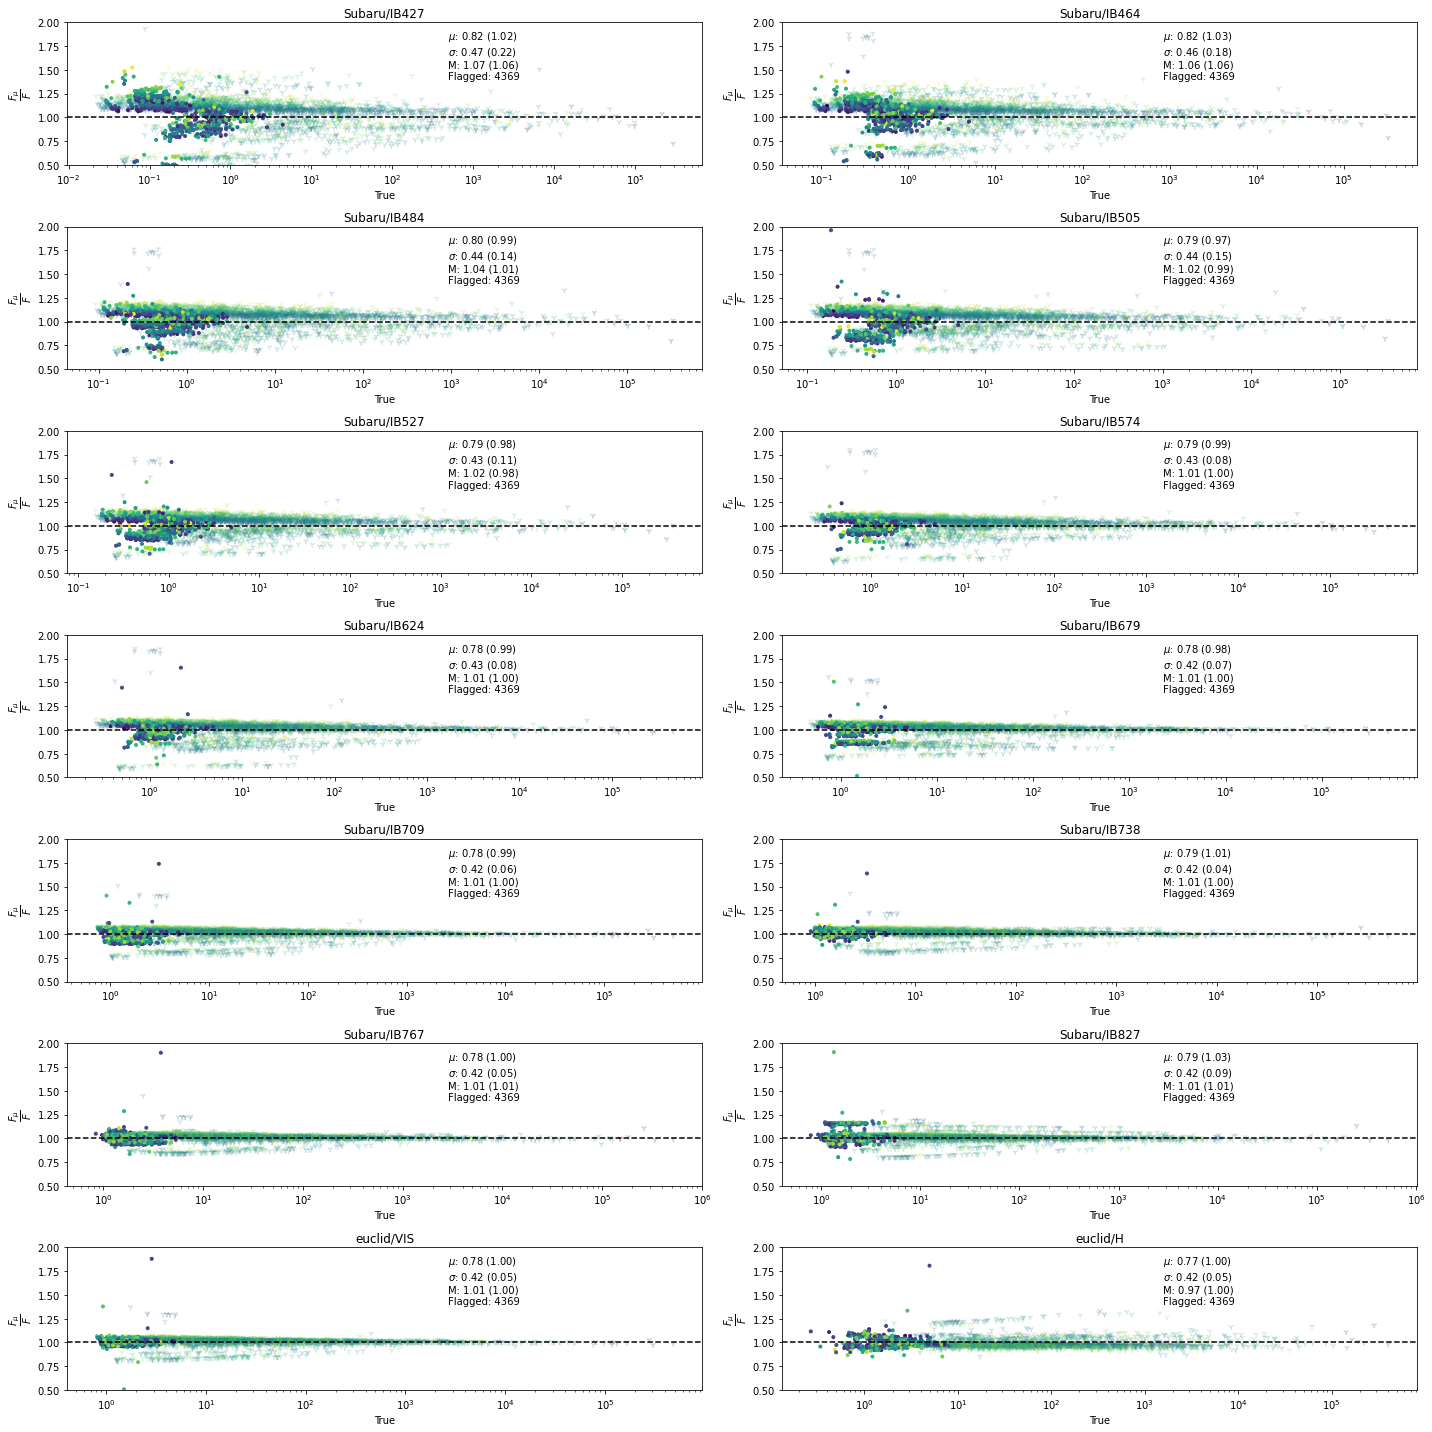

In [11]:
plot_bands(combined_matched)

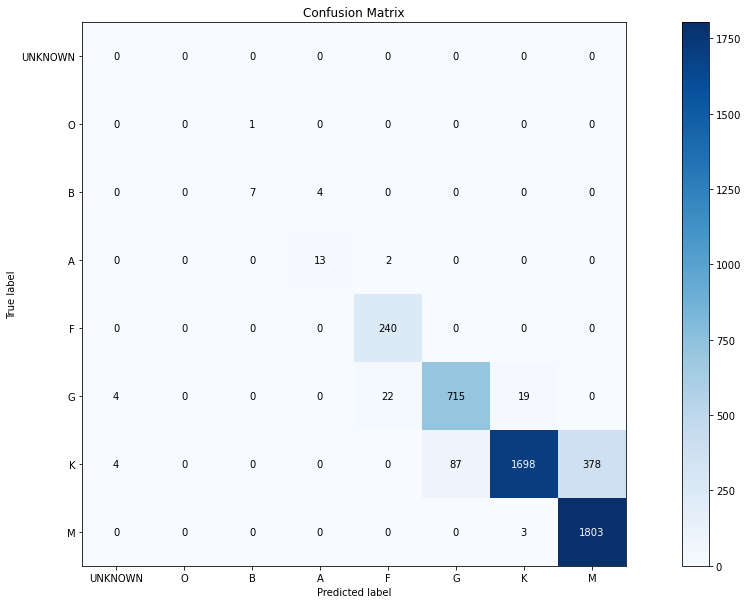

In [12]:
confusion_matrix(combined_matched)

# NNPZ with Combined (Euclidean + Chi2), EBV correction

In [13]:
nnpz_ebv = Table.read('/home/aalvarez/Work/Data/StarsSEDs/CombinedEBV.fits')
ebv_matches = join(true_photo, nnpz_ebv, 'ID')

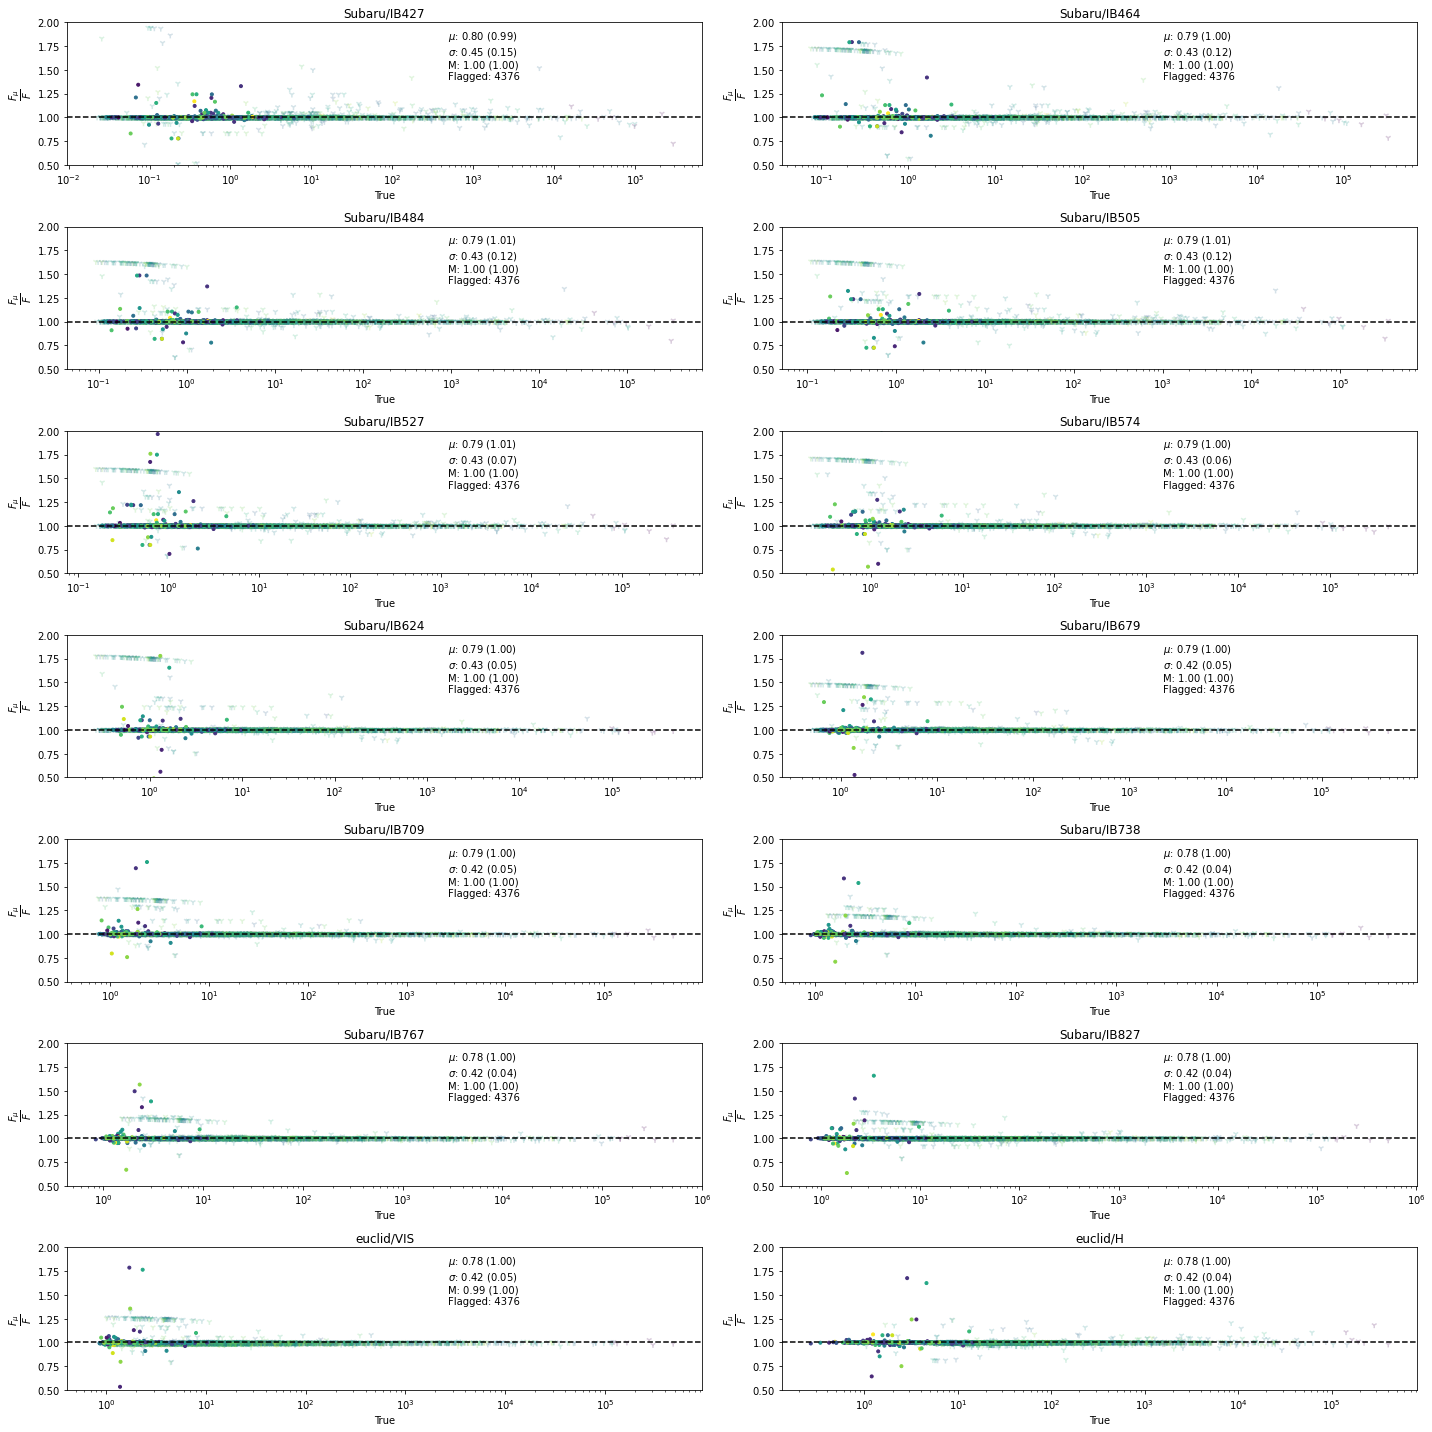

In [14]:
plot_bands(ebv_matches)

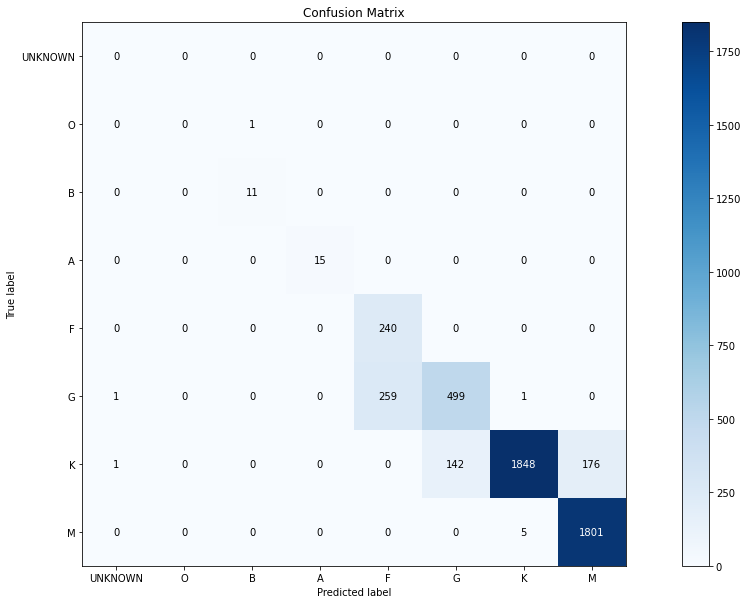

In [15]:
confusion_matrix(ebv_matches)

# NNPZ with Uniform, no EBV

In [16]:
nnpz_uniform = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Uniform.fits')
uniform_matches = join(true_photo, nnpz_uniform, 'ID')

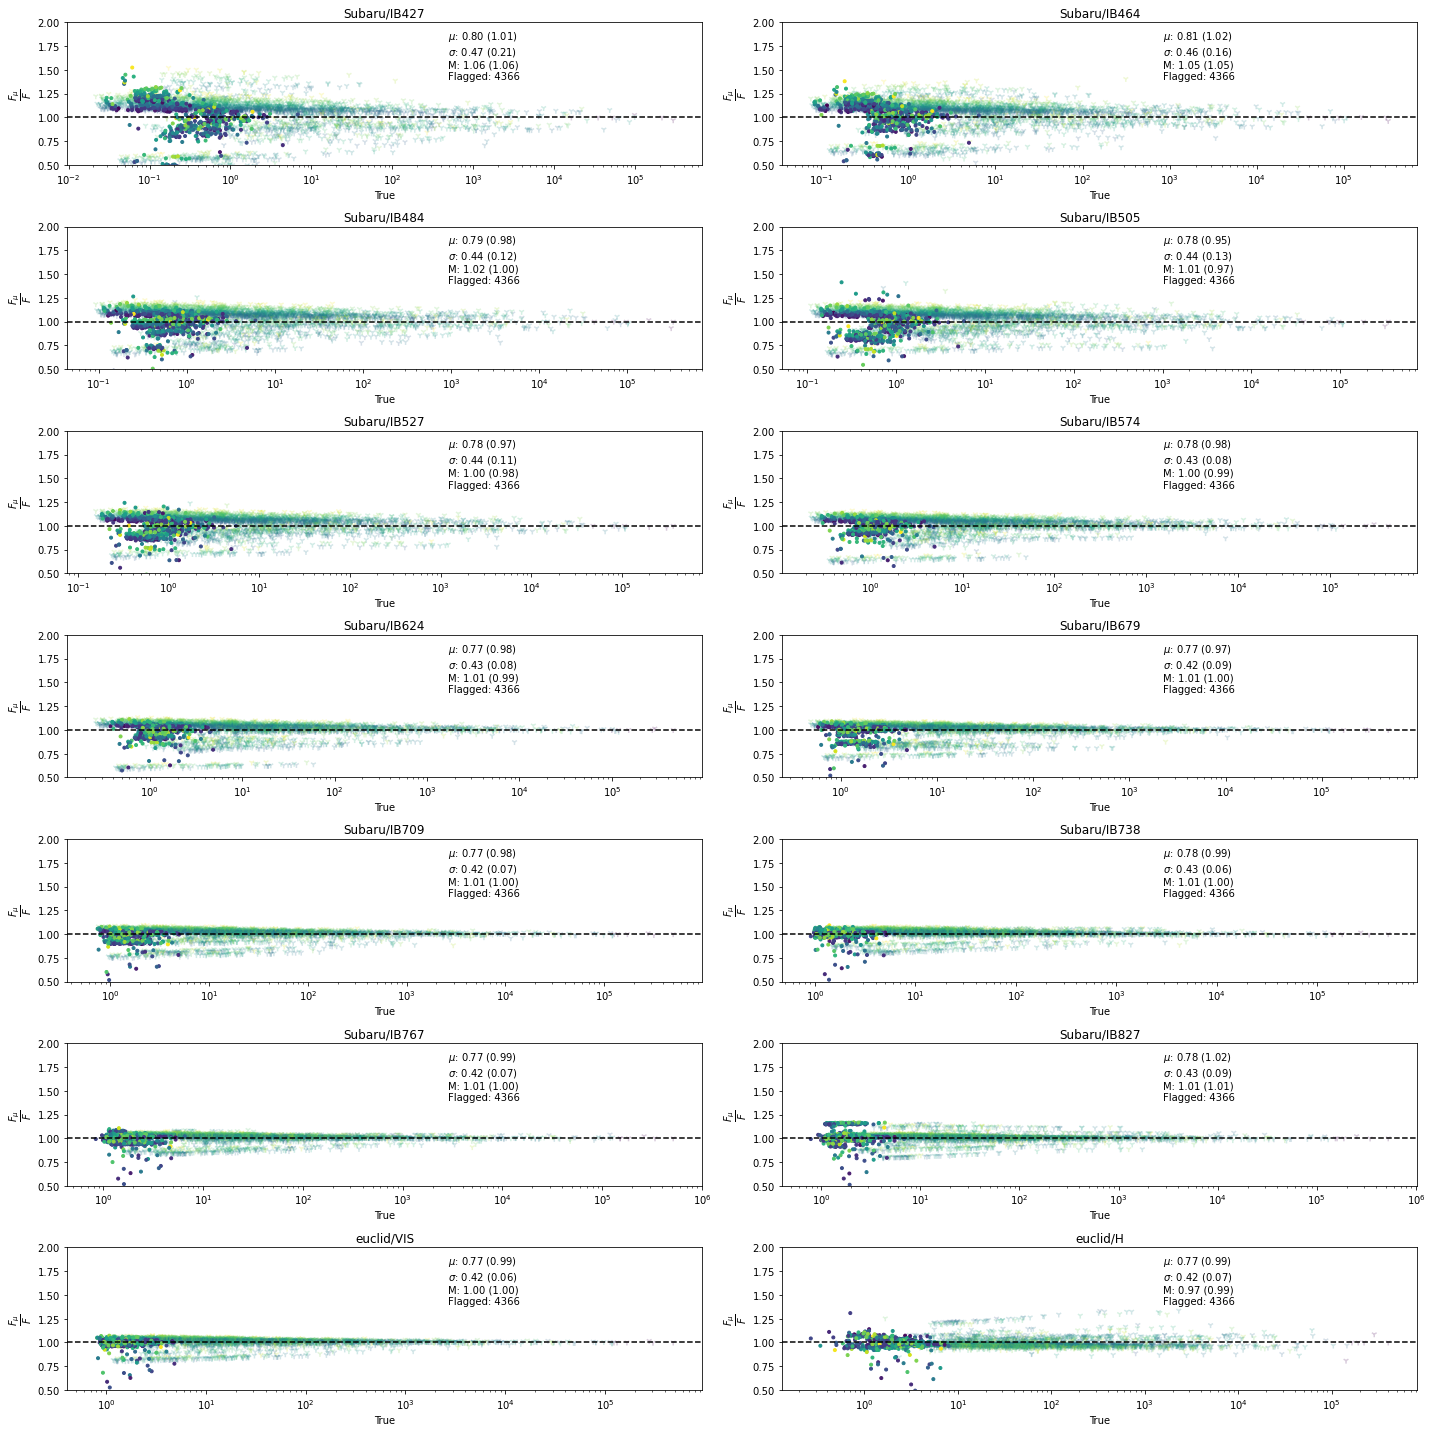

In [17]:
plot_bands(uniform_matches)

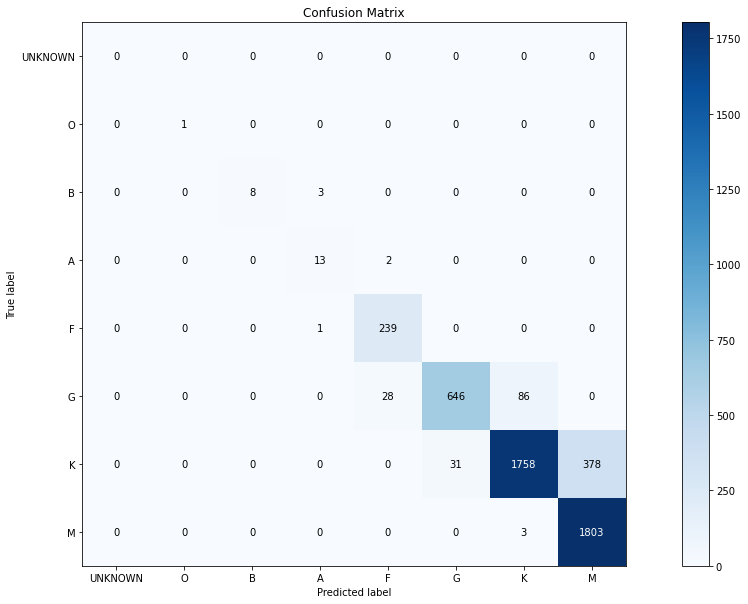

In [18]:
confusion_matrix(uniform_matches)

# NNPZ with Uniform, EBV

In [19]:
nnpz_uniform_ebv = Table.read('/home/aalvarez/Work/Data/StarsSEDs/UniformEBV.fits')
uniform_ebv_matches = join(true_photo, nnpz_uniform_ebv, 'ID')

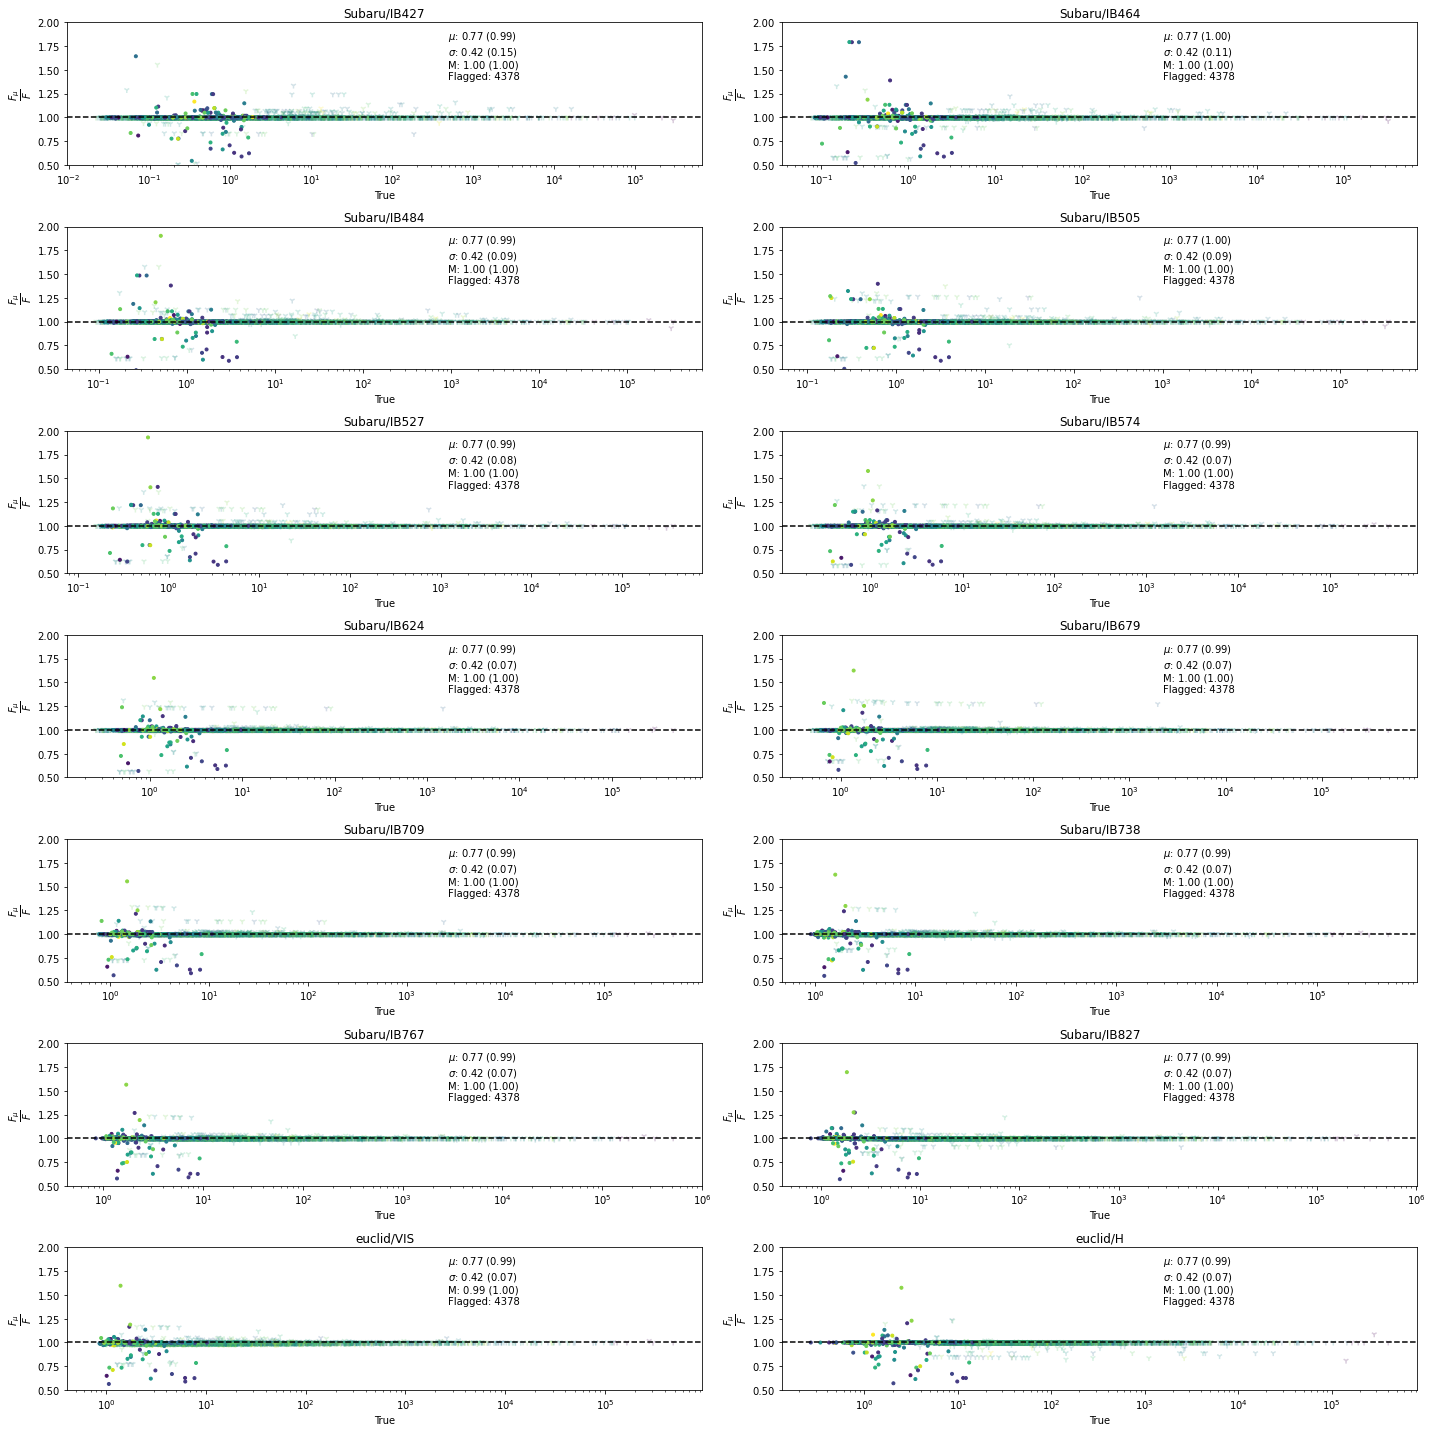

In [20]:
plot_bands(uniform_ebv_matches)

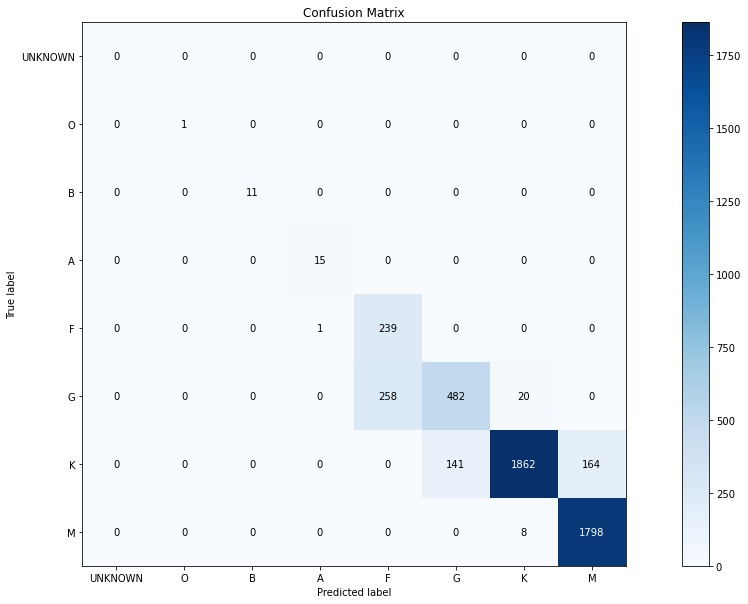

In [21]:
confusion_matrix(uniform_ebv_matches)

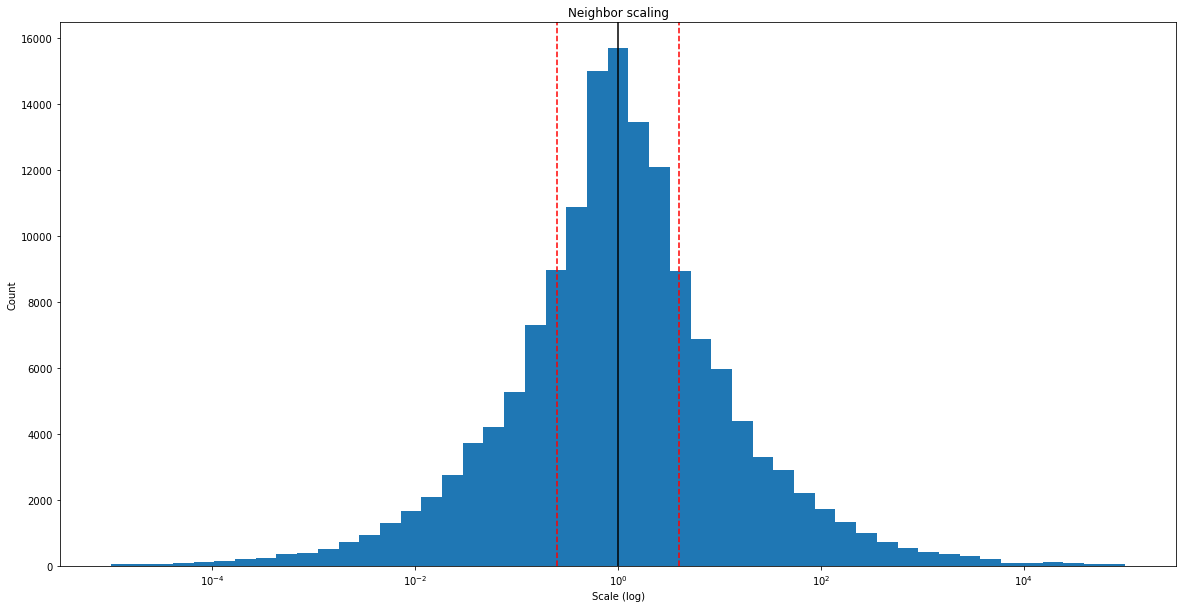

In [22]:
plt.figure()
plt.title('Neighbor scaling')
plt.hist(uniform_ebv_matches['NEIGHBOR_SCALING'].ravel(), bins=10**np.linspace(-5, 5))
plt.axvline(1, color='black', linestyle='-')
plt.axvline(4, color='red', linestyle='--')
plt.axvline(0.25, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Scale (log)')
plt.ylabel('Count')
plt.show()

# Tophat EBV (Angular)

In [23]:
nnpz_tophat_ebv = Table.read('/home/aalvarez/Work/Data/StarsSEDs/TophatEBV.fits')
tophat_ebv_matches = join(true_photo, nnpz_tophat_ebv, 'ID')

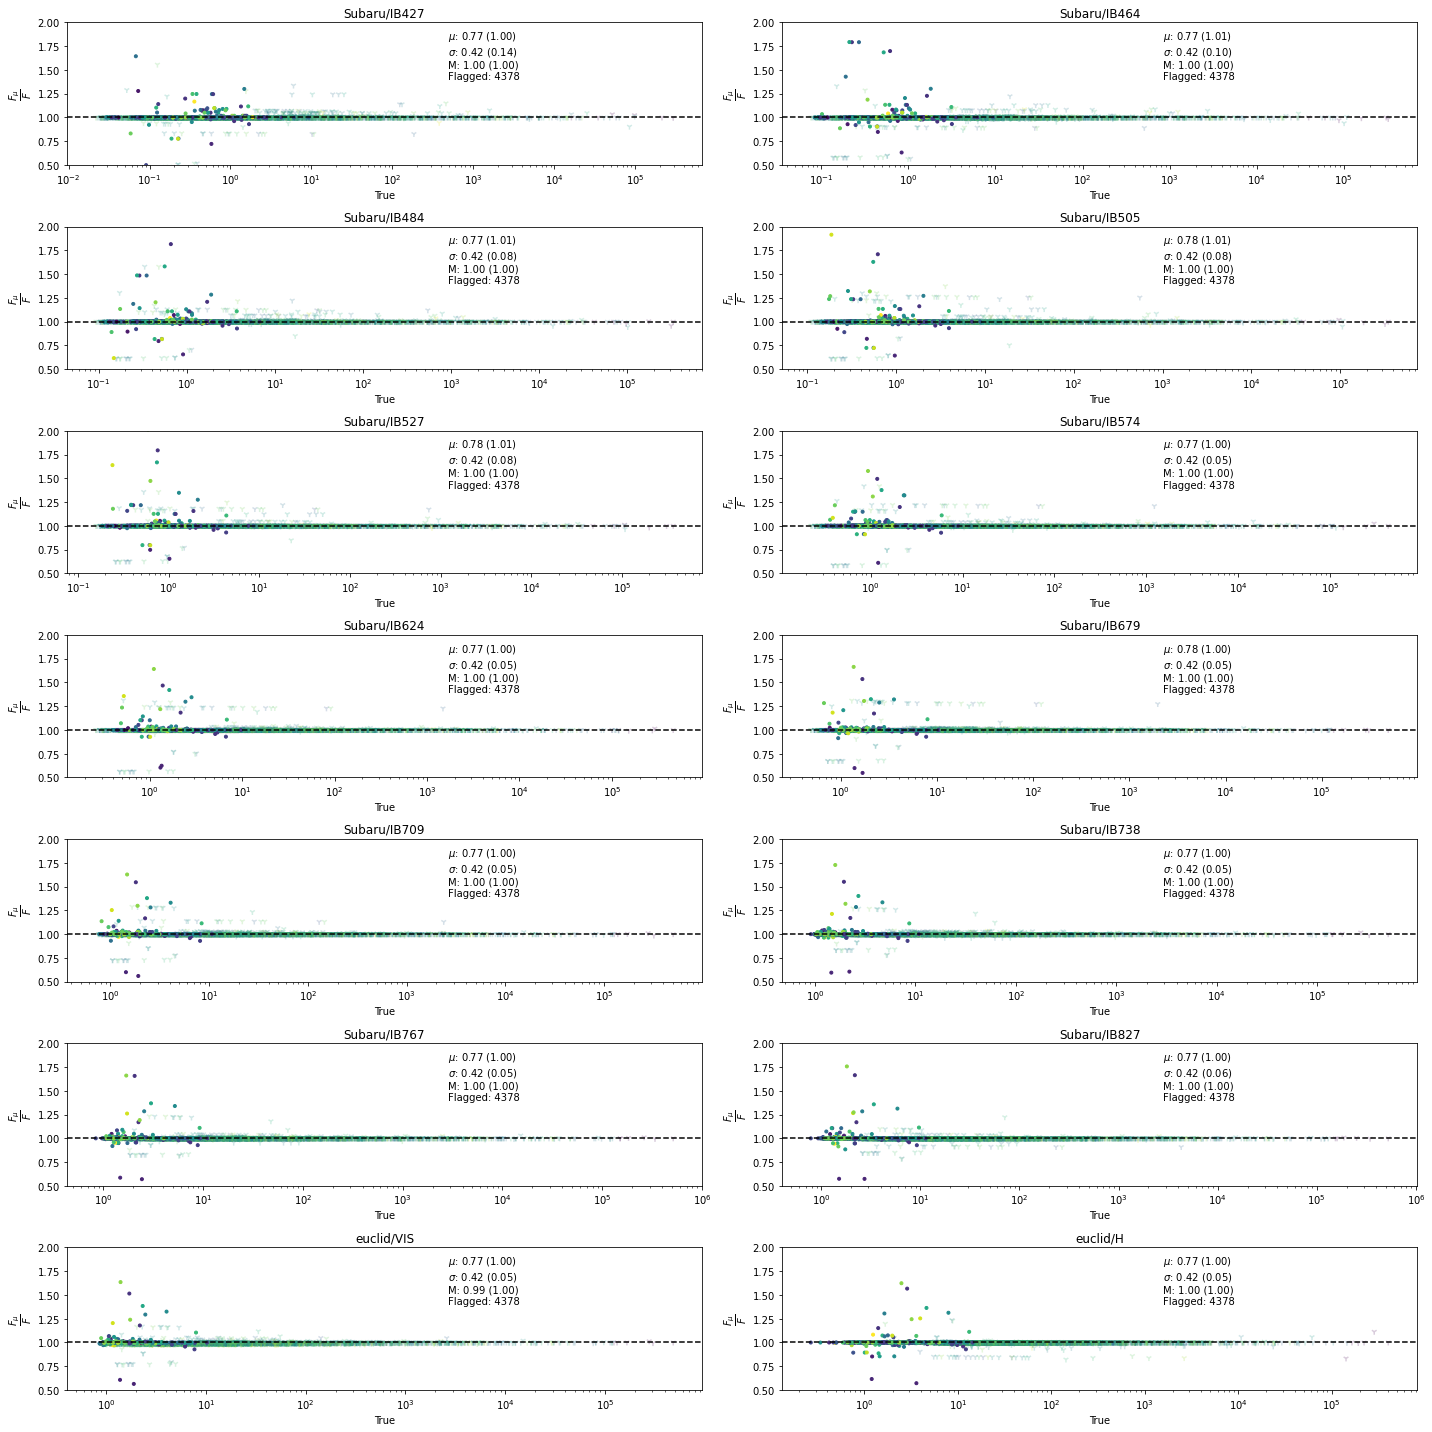

In [24]:
plot_bands(tophat_ebv_matches)

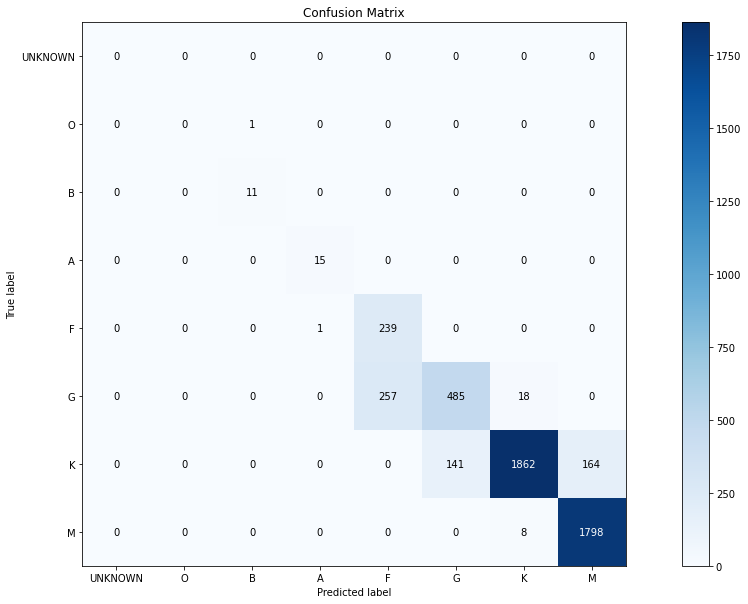

In [25]:
confusion_matrix(tophat_ebv_matches)

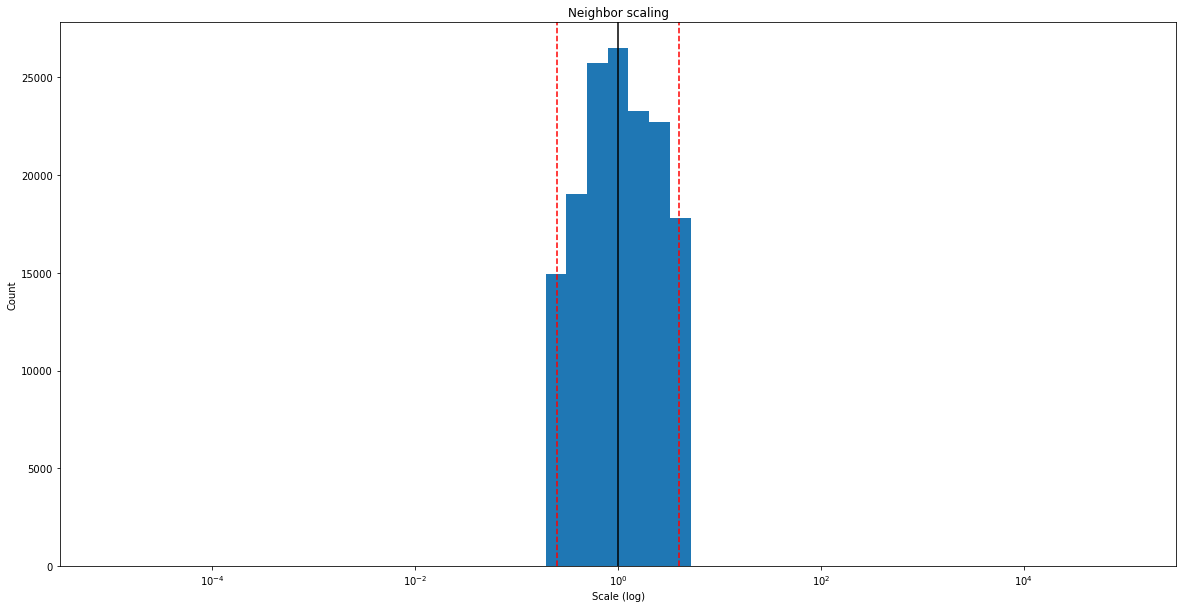

In [26]:
plt.figure()
plt.title('Neighbor scaling')
plt.hist(tophat_ebv_matches['NEIGHBOR_SCALING'].ravel(), bins=10**np.linspace(-5, 5))
plt.axvline(1, color='black', linestyle='-')
plt.axvline(4, color='red', linestyle='--')
plt.axvline(0.25, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Scale (log)')
plt.ylabel('Count')
plt.show()

# Representativity of the reference sample

In [27]:
nnpz_config = dict()
with open('/home/aalvarez/Work/Data/StarsSEDs/nnpz.conf') as nnpz_fd:
    exec(nnpz_fd.read(), nnpz_config)

In [28]:
ref_col = nnpz_config['reference_sample_phot_filters']
ref_pairs = list(zip(ref_col[:-1], ref_col[1:]))
flux_col = [flux for flux, error in nnpz_config['target_catalog_filters']]
flux_pairs = list(zip(flux_col[:-1], flux_col[1:]))

In [29]:
reference_photo = Table.read('/home/aalvarez/Work/Data/StarsSEDs/RefPhotometry.fits', hdu=1)
reference_sed = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Reference.fits')
reference = join(reference_photo, reference_sed, 'ID')

NameError: name 'uniform' is not defined

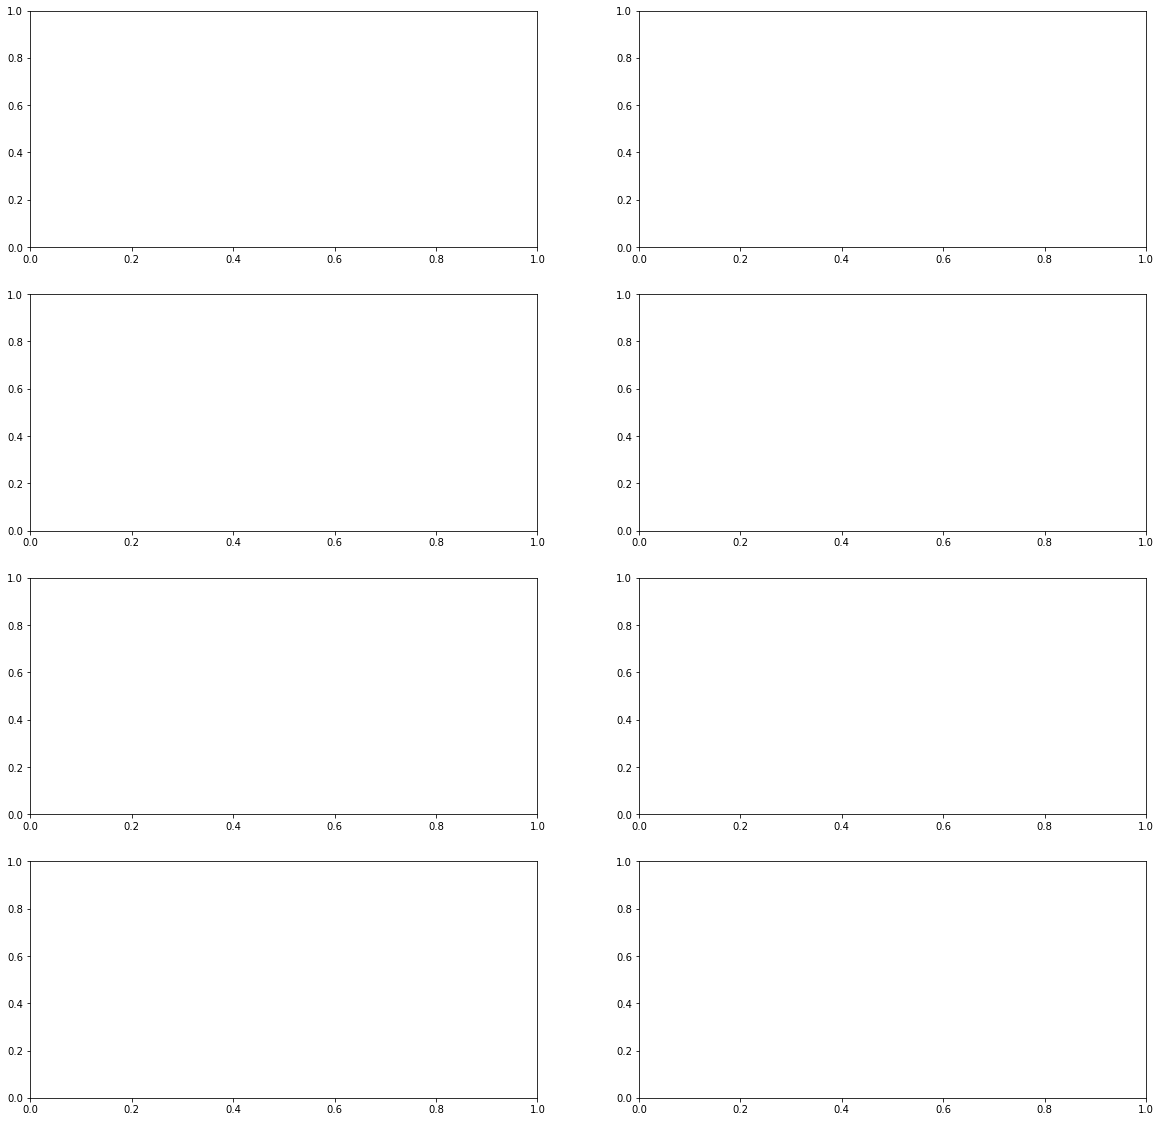

In [30]:
ncols = 2
nrows = len(flux_pairs) // ncols

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))

# A subset of the reference sample
ref_sample = np.arange(len(reference))
np.random.shuffle(ref_sample)
ref_sample = reference[ref_sample[:10000]]
target_sample = np.arange(len(uniform))
np.random.shuffle(target_sample)
target_sample = uniform[target_sample[:1000]]

for pair, ax in zip(ref_pairs, axes.ravel()):
    refx = ref_sample[pair[0]]
    refy = ref_sample[pair[1]]
    refc = ref_sample['SED-Index']
    targetx = target_sample[pair[0]]
    targety = target_sample[pair[1]]
    targetc = target_sample['SED-Index']
    ax.scatter(refx, refy, c=refc, marker='.', label='Reference')
    ax.scatter(targetx, targety, c=targetc, marker='x', label='Target', alpha=0.4)

    # Zoom
    counts, xedges, yedges = np.histogram2d(np.log10(refx), np.log10(refy), bins=20)
    imax = np.argmax(counts)
    xmax, ymax = imax // 20, imax % 20
    limx = 10**xedges[max(0, xmax-1)], 10**xedges[xmax+1]
    limy = 10**yedges[max(0, ymax-1)], 10**yedges[ymax+1]
    axins = zoomed_inset_axes(ax, 5, loc=4)
    axins.scatter(refx, refy, c=refc, marker='.')
    axins.set_xlim(*limx)
    axins.set_ylim(*limy)
    axins.set_xscale('log')
    axins.set_yscale('log')
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    ax.legend()

The photometries of the reference sample are too well aligned, so all targets that follow on the gaps will be too far away from any possible neighbor.
This would explain the amount of flagged sources.

Maybe adding noise to the reference sample could fix this.